In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets

from IPython.display import display

In [42]:
NUM_STATES = 8
NUM_OBSERVATIONS = 3
NUM_BELIEFS = 2 # TARGET vs. NON TARGET
ANGLE_RANGE = 2*np.pi

STATE_STEP = ANGLE_RANGE/NUM_STATES
STATE_CENTERS = np.arange(0, ANGLE_RANGE, STATE_STEP) + STATE_STEP
ANGL_DIST_BETWEEN_STATES = (STATE_CENTERS[np.newaxis, :] - STATE_CENTERS[:, np.newaxis])

PRIOR_TARGET_PROB = np.array([1/NUM_BELIEFS, 1-(1/NUM_BELIEFS)])
PRIOR_STATE_PROB = np.full(NUM_STATES, 1/NUM_STATES)

# prob_code0_in_states = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0])
prob_code0_in_states = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
prob_code1_in_states = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
prob_code2_in_states = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

LIKELIHOOD_OBS_DIST_FROM_NONTARGET = np.vstack([prob_code0_in_states, prob_code1_in_states, prob_code2_in_states])
LIKELIHOOD_OBS_DIST_FROM_NONTARGET

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [43]:
STATE_STEP, PRIOR_STATE_PROB

(0.7853981633974483,
 array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]))

In [44]:
def get_stochastic_state_transition_matrix(candidate_step):
    if candidate_step>0:
        mod_basis = 2*np.pi
    else:
        mod_basis = -2*np.pi

    angular_dist_between_states_in_extent = ANGL_DIST_BETWEEN_STATES % mod_basis
    angular_dist_after_action = (angular_dist_between_states_in_extent - candidate_step)
    angular_dist_after_action_in_extent = angular_dist_after_action % mod_basis
    
    sigma = STATE_STEP/2
    magnitude = 1 / np.sqrt((2*np.pi) * (sigma**2))
    state_transition = magnitude * np.exp(-0.5*((angular_dist_after_action_in_extent/sigma)**2))
    state_transition_normed = state_transition / state_transition.sum(axis=1)
    return state_transition_normed

def get_deterministic_state_transition_matrix(candidate_step):
    if candidate_step!=0:
        shift = int(candidate_step / np.abs(candidate_step))
    else:
        shift = 0

    state_matrix = np.eye(NUM_STATES)
    state_transition_matrix = np.roll(state_matrix, shift, axis=1)
    
    return state_transition_matrix

In [45]:
candidate_step = -STATE_STEP
state_transition_matrix = get_deterministic_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [46]:
candidate_step = 0
state_transition_matrix = get_deterministic_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [47]:
candidate_step = STATE_STEP
state_transition_matrix = get_deterministic_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

In [48]:
obs1_bounds1 = np.array([60, 120])
obs1_bounds2 = np.array([240, 300])

In [49]:
def observe_angle_state_pair(initial_angle):
   plt.figure(figsize=(6, 6))
   radius = 1
   radius_until = 5
   pie = np.pi
   theta_obs1 = np.linspace(np.radians(obs1_bounds1[0]), np.radians(obs1_bounds1[1]), 30)
   x_inner = radius * np.cos(theta_obs1)
   y_inner =  radius * np.sin(theta_obs1)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='blue', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='blue', linewidth=1)

   theta_obs1 = np.linspace(np.radians(obs1_bounds2[0]), np.radians(obs1_bounds2[1]), 30)
   x_inner = radius * np.cos(theta_obs1)
   y_inner =  radius * np.sin(theta_obs1)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='purple', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='purple', linewidth=1)

   theta_obs0 = np.linspace(np.radians(obs1_bounds1[1]), np.radians(obs1_bounds2[0]), 30)
   x_inner = radius * np.cos(theta_obs0)
   y_inner =  radius * np.sin(theta_obs0)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='orange', linewidth=1)

   theta_obs0 = np.linspace(np.radians(obs1_bounds2[1]), np.radians(obs1_bounds1[0])+2*pie, 30)
   x_inner = radius * np.cos(theta_obs0)
   y_inner =  radius * np.sin(theta_obs0)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='orange', linewidth=1)

   for theta in STATE_CENTERS:
      r_outer = 4 * radius_until * radius
      plt.plot([radius*np.cos(theta), r_outer*np.cos(theta)], 
               [radius*np.sin(theta), r_outer*np.sin(theta)],
                  color='k', linewidth=1.5, solid_capstyle='round', zorder=1)
      # plt.plot([radius*np.cos(theta + (STATE_STEP/2)), r_outer*np.cos(theta + (STATE_STEP/2))], 
      #          [radius*np.sin(theta + (STATE_STEP/2)), r_outer*np.sin(theta + (STATE_STEP/2))],
      #             color='k', linewidth=1, linestyle='dashed', zorder=1)
      
   if initial_angle > obs1_bounds1[0] and initial_angle < obs1_bounds1[1]:
      code_received = 1
   else:
      code_received = 0
   initial_radians = np.radians((initial_angle % 360))
   initial_state = np.floor((initial_radians + (STATE_STEP/2)) / STATE_STEP) % NUM_STATES
   plt.scatter(radius_until*radius*np.cos(initial_radians), radius_until*radius*np.sin(initial_radians),
            s=200, marker='.', facecolor='r', edgecolor='k', zorder=4, label=f'State={initial_state}\nCode={code_received}')

   plt.gca().set_aspect('equal', adjustable='box')
   plt.xticks([])
   plt.yticks([])
   GRID_EXTENT = 7
   plt.xlim(-GRID_EXTENT, GRID_EXTENT)
   plt.ylim(-GRID_EXTENT, GRID_EXTENT)
   plt.legend()
   plt.show()


In [50]:
initial_angle_slider = widgets.IntSlider(
    value=0,  
    min=0,
    max=360,
    description="Initial Angle",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="600px"),
)

interactive_plot = widgets.interactive(
    observe_angle_state_pair, initial_angle=initial_angle_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Initial Angle', layout=Layout(width='600px'), max=360, s…

In [51]:
NUM_STATES

8

In [61]:
prob_code1_in_states = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
prob_code2_in_states = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])
prob_code0_in_states = 1-(prob_code1_in_states+prob_code2_in_states)

TRUE_EMISSION_MATRIX_B = np.vstack([prob_code0_in_states, prob_code1_in_states, prob_code2_in_states])
TRUE_EMISSION_MATRIX_B

array([[1., 1., 0., 1., 1., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [104]:
prob_code1_in_states = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
prob_code2_in_states = np.array([0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 1.0, 0.5])
prob_code0_in_states = 1-(prob_code1_in_states+prob_code2_in_states)

EMISSION_MATRIX_B = np.vstack([prob_code0_in_states, prob_code1_in_states, prob_code2_in_states])
EMISSION_MATRIX_B

array([[0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0. , 0.5],
       [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0. , 0.5, 0.5, 0.5, 1. , 0.5]])

In [105]:
trial_num = 0
num_trials = 10
max_iter = 50
posterior_across_trials = np.zeros((num_trials, max_iter+1, NUM_BELIEFS))

In [107]:
joint_prob_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
joint_prob_received_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[1]))
joint_prob_obs_state_forecast_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
likelihood_received_obs_from_target_t = np.zeros(max_iter)
angles_visited = np.zeros(max_iter)
posterior_t = np.zeros((max_iter, NUM_BELIEFS))
current_entropyS_t = np.zeros(max_iter)
candidate_steps = np.array([-STATE_STEP, 0, STATE_STEP])
expected_forecast_t_S_per_step = np.zeros((max_iter, candidate_steps.shape[0]))
deltaS_t = np.zeros((max_iter, candidate_steps.shape[0]))
code_received_t = np.zeros(max_iter)

time_ind = 0
initial_angle = 0
stopping_num = 0

while time_ind<max_iter and stopping_num < 4:
    if np.isclose(posterior_t[time_ind-1], 1).any():
        stopping_num+=1

    if time_ind<1:
        angles_visited[time_ind] = initial_angle
    else:
        angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

    angle_visited_radians = np.radians((angles_visited[time_ind] % 360))
    state_visited = np.floor((angle_visited_radians) / STATE_STEP)
    code_received_t[time_ind] = np.random.choice(np.arange(NUM_OBSERVATIONS), p=TRUE_EMISSION_MATRIX_B[:,int(state_visited)])
    print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')

    if time_ind<1:
        joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
    else:
        state_transition_matrix = get_deterministic_state_transition_matrix(step_to_take)
        joint_prob_obs_state_t[time_ind] = (joint_prob_received_obs_state_t[time_ind-1] @ state_transition_matrix) * EMISSION_MATRIX_B

    joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
    likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()
    likelihood_received_obs_from_nontarget = (PRIOR_STATE_PROB*LIKELIHOOD_OBS_DIST_FROM_NONTARGET[int(code_received_t[time_ind])]).sum()

    if time_ind<1:
        likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], likelihood_received_obs_from_nontarget])
        posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
    else:
        likelihood_received_obs_from_target_given_obs_sequence = likelihood_received_obs_from_target_t[time_ind] / likelihood_received_obs_from_target_t[time_ind-1]
        likelihood_received_obs = np.array([likelihood_received_obs_from_target_given_obs_sequence, likelihood_received_obs_from_nontarget])
        posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

    if 1 in posterior_t[time_ind]:
        current_entropyS_t[time_ind] = 0
    else:
        current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

    if int(time_ind+1)>1:
        print(f"P(O1:{int(time_ind+1)},S{int(time_ind+1)}|Δθ2:{int(time_ind+1)},T)={joint_prob_received_obs_state_t[time_ind].round(2)}, P(O1:{int(time_ind+1)}|Δθ2:{int(time_ind+1)},T)={likelihood_received_obs_from_target_t[time_ind]}, P(S{int(time_ind+1)}|O1:{int(time_ind+1)},Δθ2:{int(time_ind+1)},T)={(joint_prob_received_obs_state_t[time_ind]/likelihood_received_obs_from_target_t[time_ind]).round(2)}, P(T|O1:{int(time_ind+1)},Δθ2:{int(time_ind+1)})={posterior_t[time_ind]}, H{int(time_ind+1)}={current_entropyS_t[time_ind]:.2f}")
    else:
        print(f"P(O1:{int(time_ind+1)},S{int(time_ind+1)}|Δθ2:{int(time_ind+1)},T)={joint_prob_received_obs_state_t[time_ind].round(2)}, P(O1:{int(time_ind+1)}|Δθ2:{int(time_ind+1)},T)={likelihood_received_obs_from_target_t[time_ind]}, P(S{int(time_ind+1)}|O1:{int(time_ind+1)},Δθ2:{int(time_ind+1)},T)={(joint_prob_received_obs_state_t[time_ind]/likelihood_received_obs_from_target_t[time_ind]).round(2)}, P(T|O1:{int(time_ind+1)},Δθ2:{int(time_ind+1)})={posterior_t[time_ind]}, H{int(time_ind+1)}={current_entropyS_t[time_ind]:.2f}")

    for i, forecast_t_candidate_step in enumerate(candidate_steps):
        state_transition_matrix = (get_deterministic_state_transition_matrix(forecast_t_candidate_step))

        joint_prob_obs_state_forecast_t[time_ind] = (joint_prob_received_obs_state_t[time_ind] @ state_transition_matrix) * EMISSION_MATRIX_B
        likelihood_obs_from_target_forecast_t = joint_prob_obs_state_forecast_t[time_ind].sum(axis=1)
        likelihood_obs_from_target_forecast_t_given_received_obs = likelihood_obs_from_target_forecast_t / likelihood_received_obs_from_target_t[time_ind]
        print(f'If Δθ{int(time_ind+2)}={forecast_t_candidate_step:.2f}, P(O1:{int(time_ind+2)},S{int(time_ind+1)}|T)=\n[{joint_prob_obs_state_forecast_t[time_ind][0].round(2)},\n{joint_prob_obs_state_forecast_t[time_ind][1].round(2)},\n{joint_prob_obs_state_forecast_t[time_ind][2].round(2)}]')
        print(f'P(O{int(time_ind+2)}|O1:{int(time_ind+1)},Δθ2:{int(time_ind+2)},T)={likelihood_obs_from_target_forecast_t_given_received_obs}')

        forecasted_S = np.zeros(NUM_OBSERVATIONS)
        prob_obs_at_forecast_t2_given_obs_at_t1 = np.zeros(NUM_OBSERVATIONS)
        posterior_forecast_given_received_obs = np.zeros((NUM_OBSERVATIONS, NUM_BELIEFS))
        for obs in range(NUM_OBSERVATIONS):
            likelihood_forecasted_obs_from_nontarget = (PRIOR_STATE_PROB*LIKELIHOOD_OBS_DIST_FROM_NONTARGET[obs]).sum()
            likelihood_obs_forecast_t_given_received_obs = np.array([likelihood_obs_from_target_forecast_t_given_received_obs[obs], likelihood_forecasted_obs_from_nontarget])
            if (posterior_t[time_ind] * likelihood_obs_forecast_t_given_received_obs).sum() > 0:
                posterior_forecast_given_received_obs[obs] = (posterior_t[time_ind] * likelihood_obs_forecast_t_given_received_obs) / (posterior_t[time_ind] * likelihood_obs_forecast_t_given_received_obs).sum()
            else:
                posterior_forecast_given_received_obs[obs] = np.array([0, 1])
            if 0 in posterior_forecast_given_received_obs[obs]:
                forecasted_S[obs] = 0
            else:
                forecasted_S[obs] = (-posterior_forecast_given_received_obs[obs] * np.log2(posterior_forecast_given_received_obs[obs])).sum()
            prob_obs_at_forecast_t2_given_obs_at_t1[obs] = (posterior_t[time_ind] * likelihood_obs_forecast_t_given_received_obs).sum()

        expected_forecast_t_S = (forecasted_S * prob_obs_at_forecast_t2_given_obs_at_t1).sum()
        print(f'S{int(time_ind+2)}={prob_obs_at_forecast_t2_given_obs_at_t1[0]:.3f}x{forecasted_S[0]:.3f} + {prob_obs_at_forecast_t2_given_obs_at_t1[1]:.3f}x{forecasted_S[1]:.3f} + {prob_obs_at_forecast_t2_given_obs_at_t1[2]:.3f}x{forecasted_S[2]:.3f}={expected_forecast_t_S}')
        expected_forecast_t_S_per_step[time_ind, i] = expected_forecast_t_S

    deltaS_t[time_ind] = current_entropyS_t[time_ind] - expected_forecast_t_S_per_step[time_ind]
    print(f'S{int(time_ind+1)}={current_entropyS_t[time_ind]}, S{int(time_ind+2)}={expected_forecast_t_S_per_step[time_ind]}, ΔS{int(time_ind+1)}→{int(time_ind+2)}={deltaS_t[time_ind]}')

    unique, counts = np.unique(deltaS_t[time_ind], return_counts=True)
    frequent_cond = counts>1
    unique_frequent_delta_S = unique[frequent_cond]
    if (counts[unique==deltaS_t[time_ind].max()]==1).all():
        print('Choosing according to max ΔS')
        step_to_take = candidate_steps[deltaS_t[time_ind].argmax()]
    else:
        if deltaS_t[time_ind].sum()>0:
            print(f'Choosing randomly between {candidate_steps[np.where(deltaS_t[time_ind]==unique_frequent_delta_S)[0]]}')
            step_to_take = candidate_steps[np.random.choice(np.where(deltaS_t[time_ind]==unique_frequent_delta_S)[0])]
        else:
            step_to_take = 0

    time_ind+=1

posterior_across_trials[trial_num,:time_ind+1,:] = np.vstack([PRIOR_TARGET_PROB, posterior_t[:time_ind]])

Current angle: 0.0, Code received: 0.0
P(O1:1,S1|Δθ2:1,T)=[0.06 0.06 0.   0.06 0.06 0.06 0.   0.06], P(O1:1|Δθ2:1,T)=0.375, P(S1|O1:1,Δθ2:1,T)=[0.17 0.17 0.   0.17 0.17 0.17 0.   0.17], P(T|O1:1,Δθ2:1)=[0.42857143 0.57142857], H1=0.99
If Δθ2=-0.79, P(O1:2,S1|T)=
[[0.03 0.   0.   0.03 0.03 0.   0.   0.03],
[0.   0.   0.06 0.   0.   0.   0.   0.  ],
[0.03 0.   0.   0.03 0.03 0.   0.06 0.03]]
P(O2|O1:1,Δθ2:2,T)=[0.33333333 0.16666667 0.5       ]
S2=0.429x0.918 + 0.071x0.000 + 0.500x0.985=0.8861694254690498
If Δθ2=0.00, P(O1:2,S1|T)=
[[0.03 0.03 0.   0.03 0.03 0.03 0.   0.03],
[0. 0. 0. 0. 0. 0. 0. 0.],
[0.03 0.03 0.   0.03 0.03 0.03 0.   0.03]]
P(O2|O1:1,Δθ2:2,T)=[0.5 0.  0.5]
S2=0.500x0.985 + 0.000x0.000 + 0.500x0.985=0.9852281360342515
If Δθ2=0.79, P(O1:2,S1|T)=
[[0.03 0.03 0.   0.   0.03 0.03 0.   0.  ],
[0.   0.   0.06 0.   0.   0.   0.   0.  ],
[0.03 0.03 0.   0.   0.03 0.03 0.06 0.  ]]
P(O2|O1:1,Δθ2:2,T)=[0.33333333 0.16666667 0.5       ]
S2=0.429x0.918 + 0.071x0.000 + 0.500x0.985=0

In [101]:
import matplotlib.animation as animation

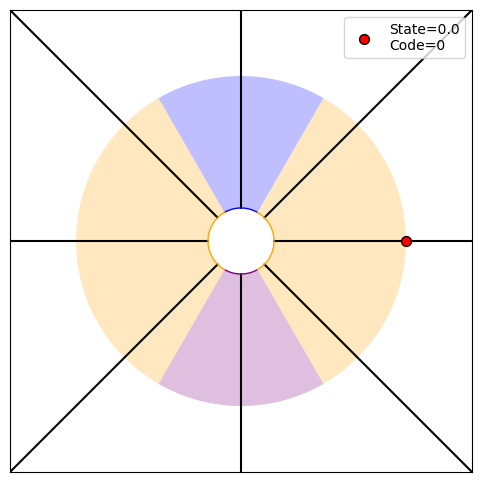

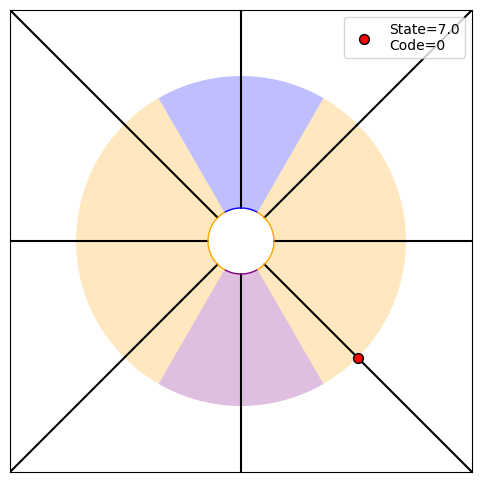

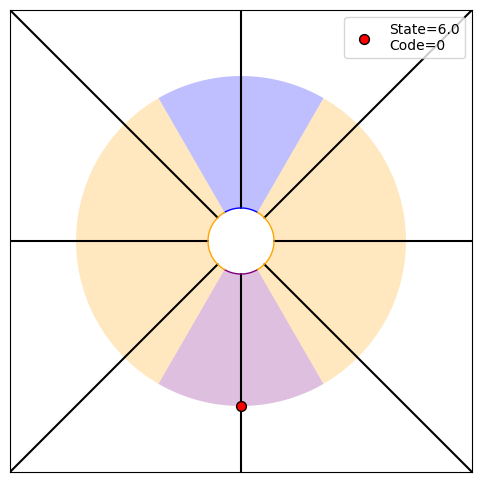

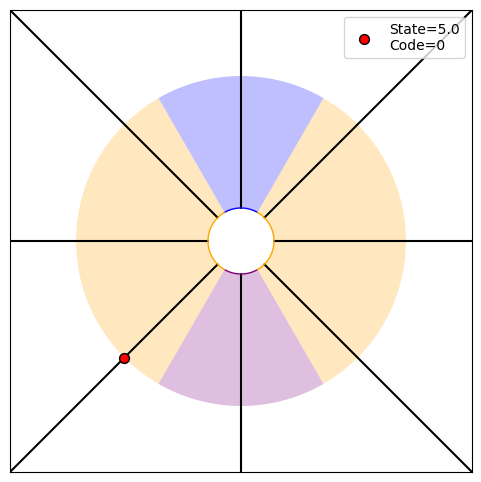

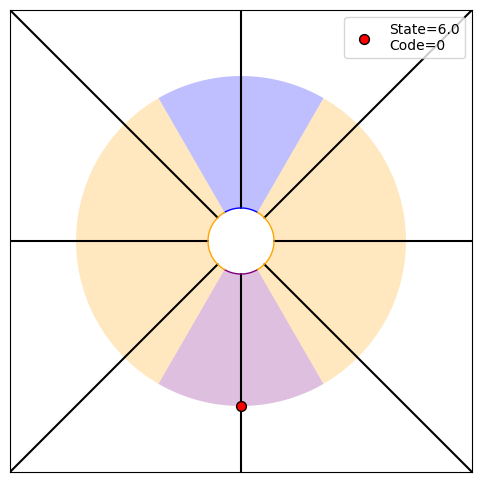

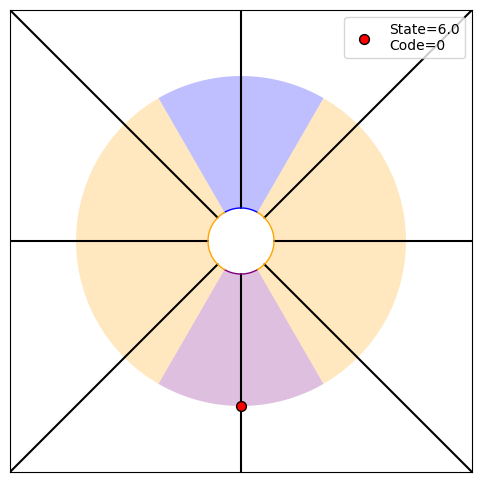

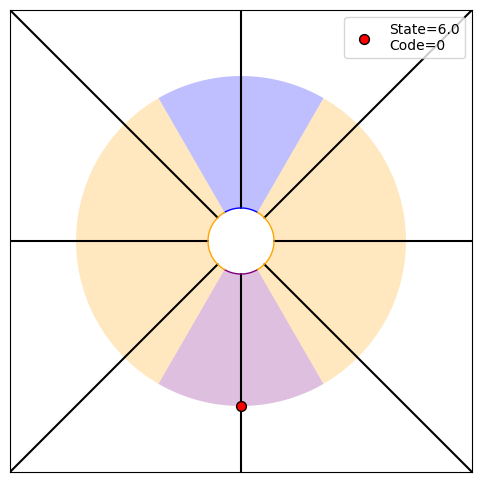

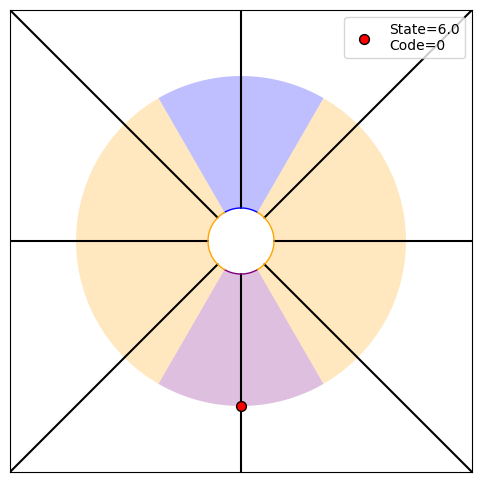

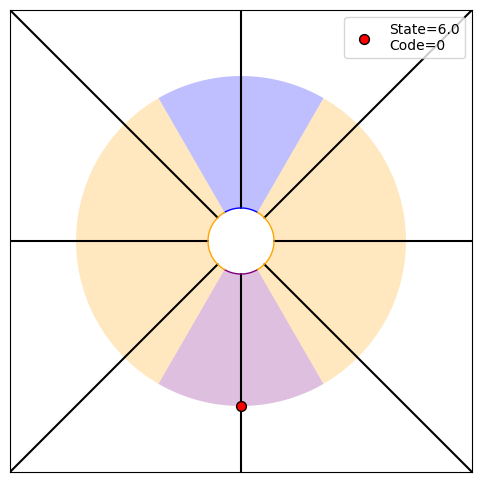

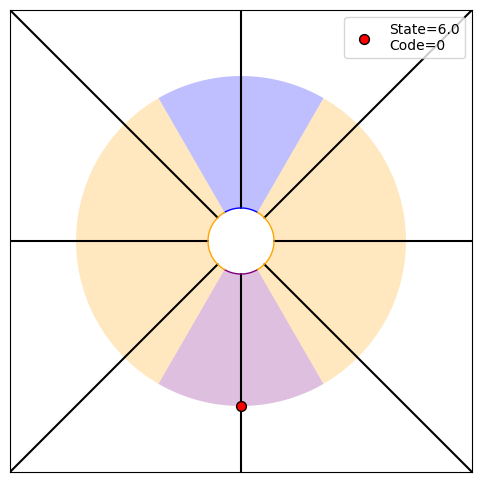

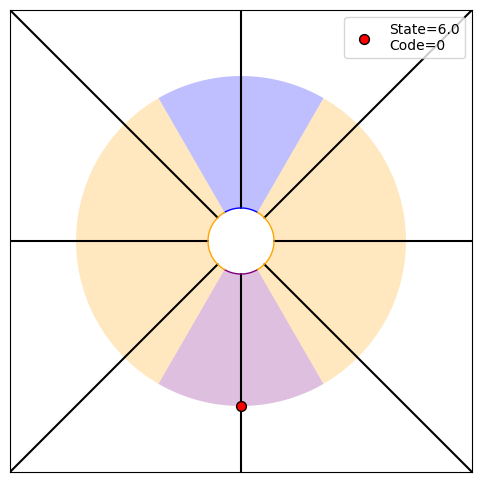

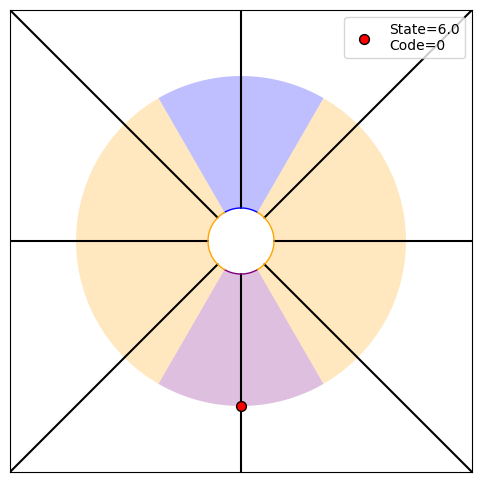

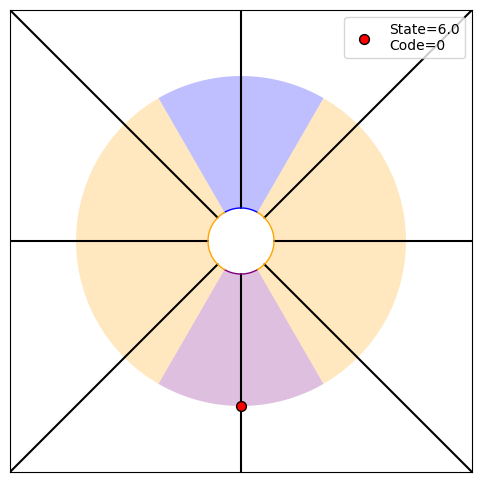

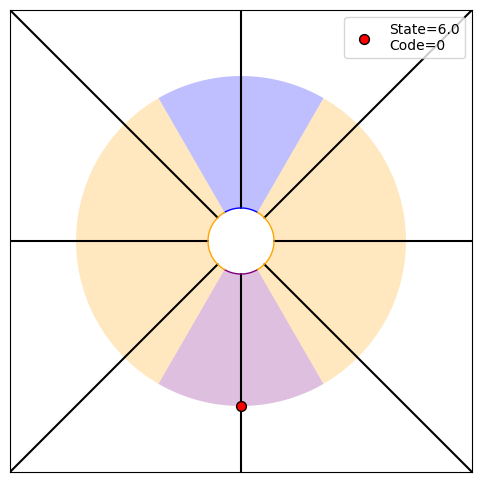

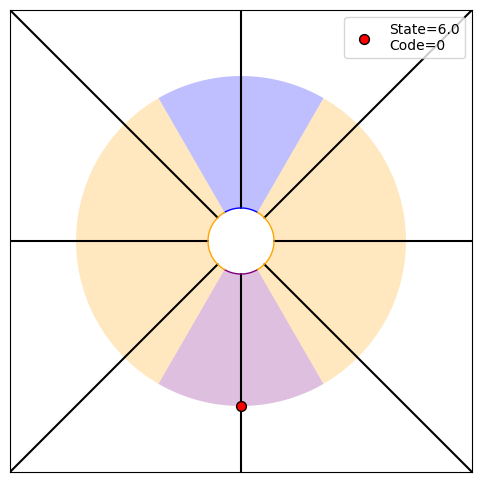

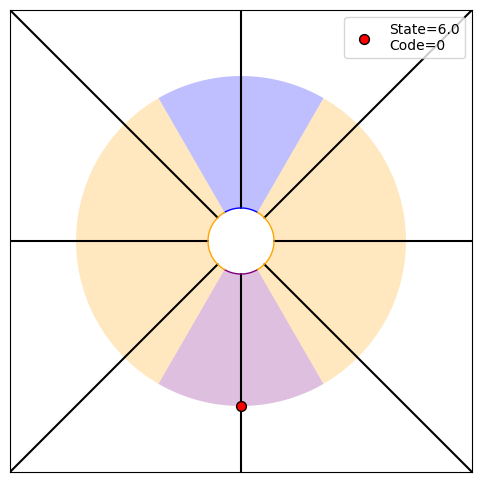

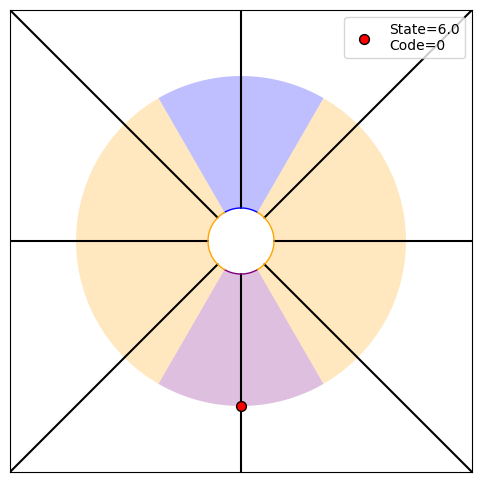

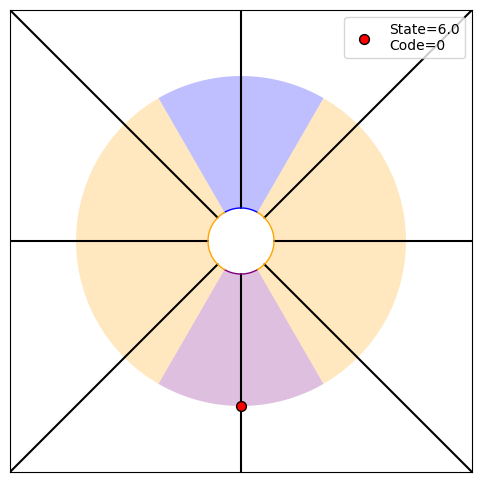

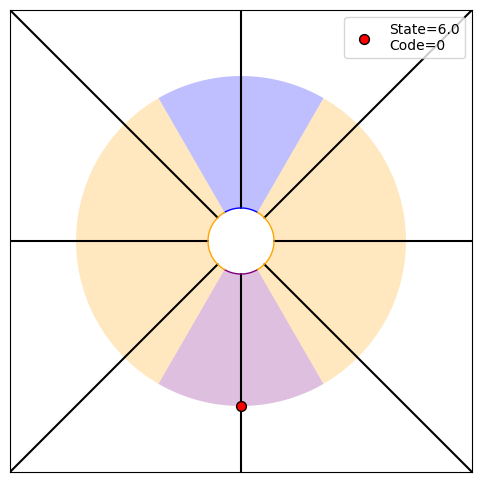

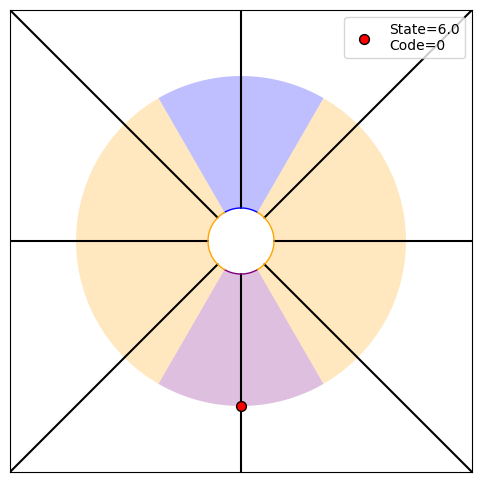

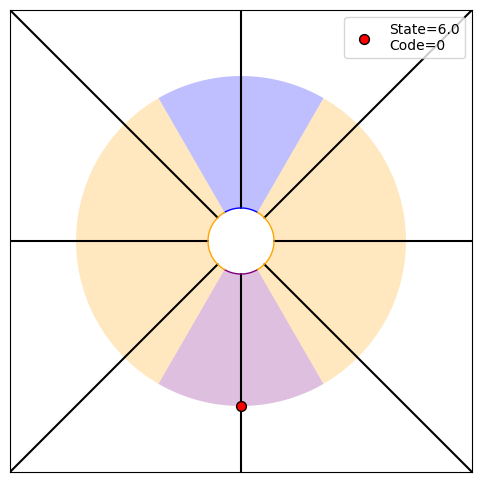

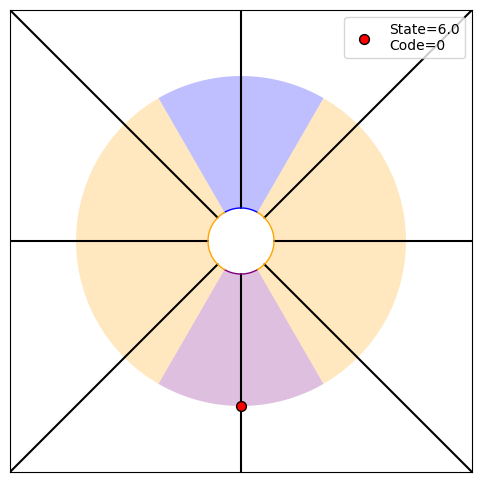

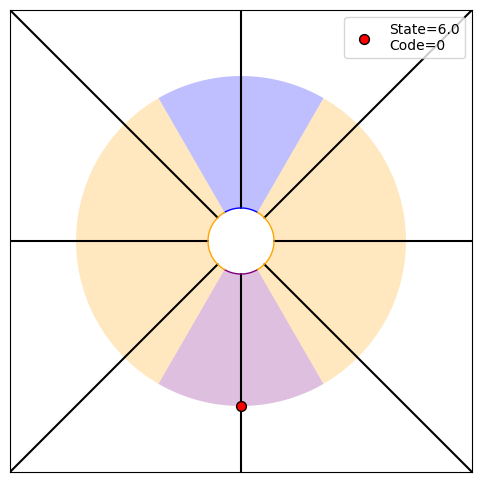

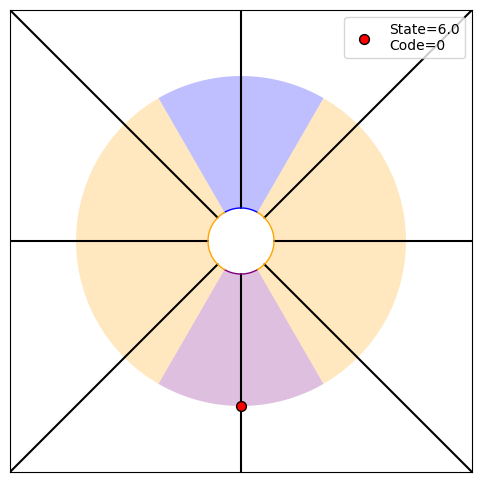

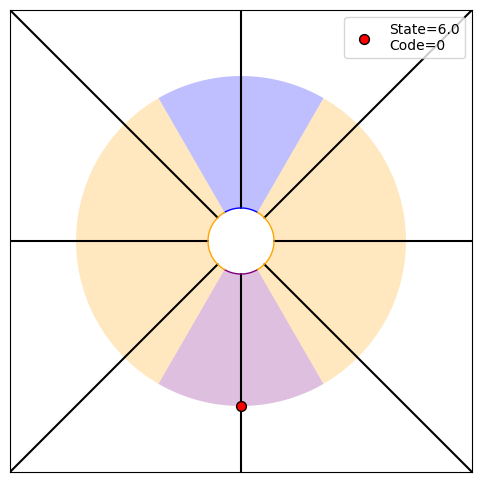

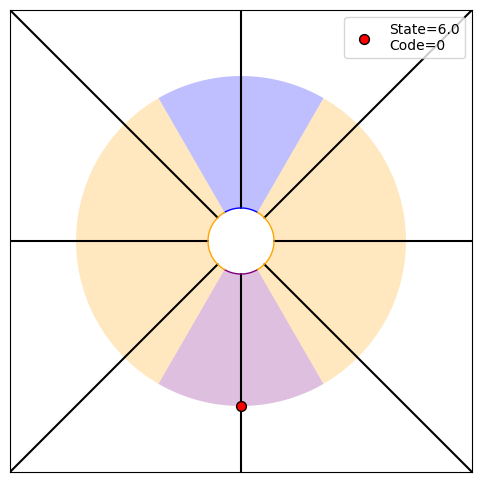

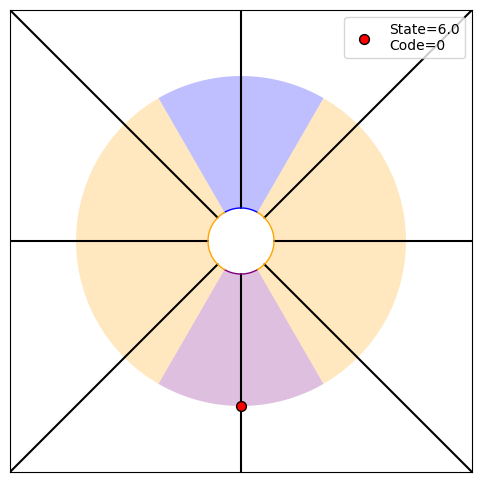

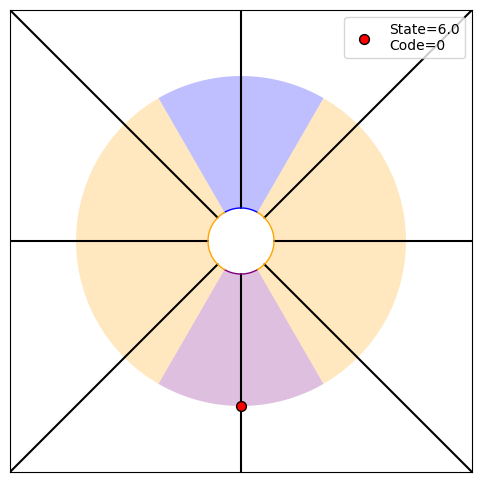

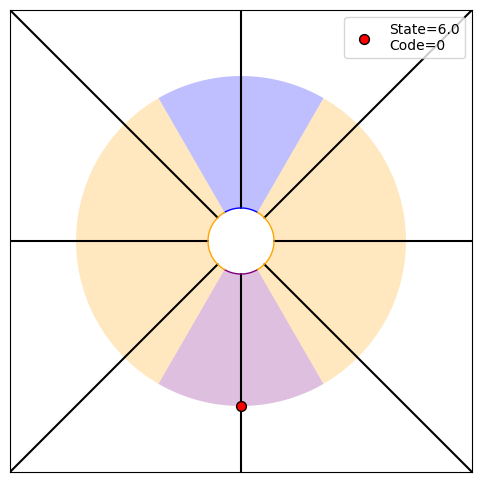

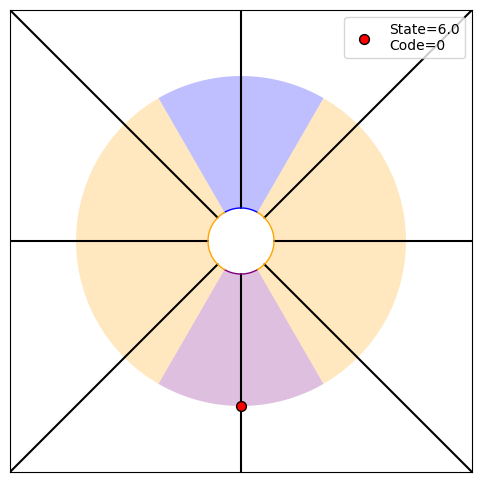

In [102]:
time_ind = 0
stopping_num = 0
trial_stop_time_ind = 0
while time_ind<max_iter and stopping_num < 4:
    if np.isclose(posterior_t[time_ind], 1).any():
        stopping_num+=1
    observe_angle_state_pair((angles_visited[time_ind]%360))
    time_ind+=1
    trial_stop_time_ind = time_ind

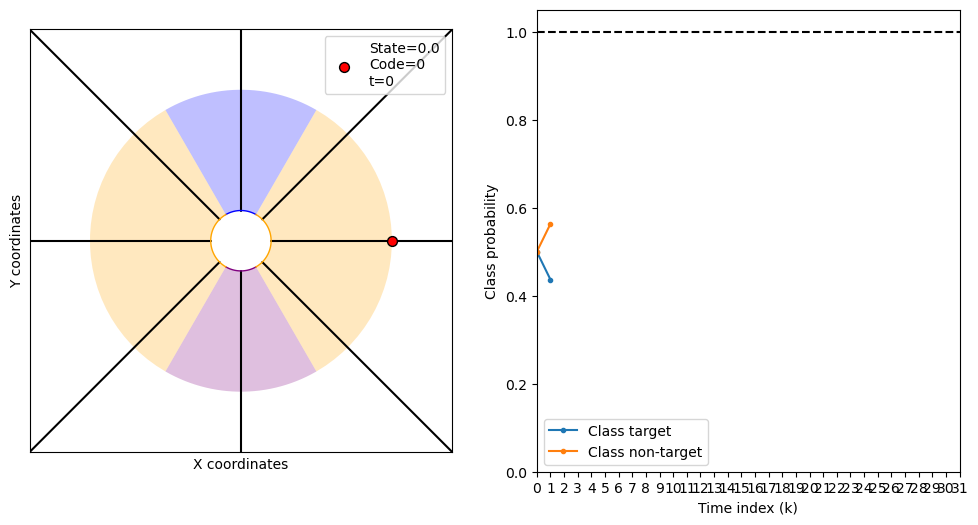

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

def update(time_ind):
    ax_grid = ax[0]
    ax_diffusion = ax[1]
    ax_grid.cla()
    ax_diffusion.cla()

    radius = 1
    radius_until = 5
    pie = np.pi
    theta_obs1 = np.linspace(np.radians(obs1_bounds1[0]), np.radians(obs1_bounds1[1]), 30)
    x_inner = radius * np.cos(theta_obs1)
    y_inner =  radius * np.sin(theta_obs1)
    x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
    y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
    ax_grid.fill(x_poly, y_poly, facecolor='blue', alpha=0.25, linewidth=0)
    ax_grid.plot(x_inner, y_inner, color='blue', linewidth=1)

    theta_obs1 = np.linspace(np.radians(obs1_bounds2[0]), np.radians(obs1_bounds2[1]), 30)
    x_inner = radius * np.cos(theta_obs1)
    y_inner =  radius * np.sin(theta_obs1)
    x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
    y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
    ax_grid.fill(x_poly, y_poly, facecolor='purple', alpha=0.25, linewidth=0)
    ax_grid.plot(x_inner, y_inner, color='purple', linewidth=1)

    theta_obs0 = np.linspace(np.radians(obs1_bounds1[1]), np.radians(obs1_bounds2[0]), 30)
    x_inner = radius * np.cos(theta_obs0)
    y_inner =  radius * np.sin(theta_obs0)
    x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
    y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
    ax_grid.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
    ax_grid.plot(x_inner, y_inner, color='orange', linewidth=1)

    theta_obs0 = np.linspace(np.radians(obs1_bounds2[1]), np.radians(obs1_bounds1[0])+2*pie, 30)
    x_inner = radius * np.cos(theta_obs0)
    y_inner =  radius * np.sin(theta_obs0)
    x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
    y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
    ax_grid.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
    ax_grid.plot(x_inner, y_inner, color='orange', linewidth=1)

    for theta in STATE_CENTERS:
        r_outer = 4 * radius_until * radius
        ax_grid.plot([radius*np.cos(theta), r_outer*np.cos(theta)], 
                [radius*np.sin(theta), r_outer*np.sin(theta)],
                    color='k', linewidth=1.5, solid_capstyle='round', zorder=1)
        
    if (angles_visited[time_ind]%360) >= obs1_bounds1[0] and (angles_visited[time_ind]%360) <= obs1_bounds1[1]:
        code_received = 1
    elif (angles_visited[time_ind]%360) >= obs1_bounds2[0] and (angles_visited[time_ind]%360) <= obs1_bounds2[1]:
        code_received = 1
    else:
        code_received = 0
    initial_radians = np.radians(((angles_visited[time_ind]%360) % 360))
    initial_state = np.floor((initial_radians) / STATE_STEP)
    ax_grid.scatter(radius_until*radius*np.cos(initial_radians), radius_until*radius*np.sin(initial_radians),
            s=200, marker='.', facecolor='r', edgecolor='k', zorder=4, label=f'State={initial_state}\nCode={code_received}\nt={time_ind}')
    
    ax_grid.set_aspect('equal', adjustable='box')
    ax_grid.set_xticks([])
    ax_grid.set_yticks([])
    ax_grid.set_ylabel('Y coordinates')
    ax_grid.set_xlabel('X coordinates')
    GRID_EXTENT = 7
    ax_grid.set_xlim(-GRID_EXTENT, GRID_EXTENT)
    ax_grid.set_ylim(-GRID_EXTENT, GRID_EXTENT)
    ax_grid.legend()

    for i in range(NUM_BELIEFS):
        if i == 0:
            class_name = 'target'
        else:
            class_name = 'non-target'
        ax_diffusion.plot(np.vstack([PRIOR_TARGET_PROB, posterior_t[:max(0,time_ind+1)]])[:,i], marker='.', label=f'Class {class_name}')
    ax_diffusion.axhline(y=1.0, linestyle='dashed', color='k')
    ax_diffusion.set_xlim(0, trial_stop_time_ind+1)
    ax_diffusion.set_ylim(0, 1.05)
    ax_diffusion.set_xticks(np.arange(trial_stop_time_ind+2).astype(int))
    ax_diffusion.set_ylabel('Class probability')
    ax_diffusion.set_xlabel('Time index (k)')
    ax_diffusion.legend()

ani = animation.FuncAnimation(fig=fig, func=update, frames=trial_stop_time_ind, interval=600)
ani.save('test.gif')

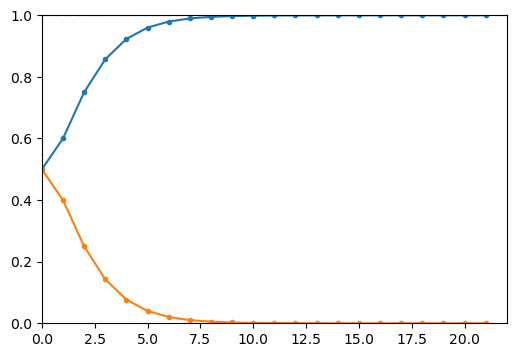

In [59]:
plt.figure(figsize=(6,4))
plt.plot(np.vstack([PRIOR_TARGET_PROB, posterior_t[:trial_stop_time_ind]]), marker='.')
plt.axhline(y=1.0, linestyle='dashed', color='k')
plt.xlim(0, time_ind+1)
plt.ylim(0, 1.0)
plt.show()